In [2]:
import sys
import os
import pandas as pd
import numpy as np 
import folium   
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

sys.path.append(os.path.abspath('..'))  # Add the parent directory to the sys.path
from utils.utils import *

%reload_ext autoreload
%autoreload 2

# **Data Import**

In [6]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), '../../data/raw'))

basket_path = os.path.join(base_dir, 'customer_basket.csv')
customer_info_path = os.path.join(base_dir, 'customer_info.csv')
product_path = os.path.join(base_dir, 'product_mapping.xlsx')

basket = pd.read_csv(basket_path, index_col='invoice_id')
customer_info = pd.read_csv(customer_info_path, index_col='customer_id')
product = pd.read_excel(product_path)

In [7]:
basket.head(3)

,list_of_goods,customer_id
invoice_id,,
7448187,"['olive oil', 'yogurt cake', 'grated cheese', ...",43134
3167314,"['babies food', 'shower gel', 'rice', 'black b...",43134
10199712,"['babies food', 'barbecue sauce', 'olive oil',...",43134


In [5]:
product.head(3)

,product_name,category
0,champagne,alcohol_drinks
1,bramble,alcohol_drinks
2,white wine,alcohol_drinks


In [44]:
customer_info.head(3)

,Unnamed: 0,customer_name,customer_gender,customer_birthdate,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,...,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,loyalty_card_number,latitude,longitude
customer_id,,,,,,,,,,,,,,,,,,,,,
39634,0,David Frink,male,05/15/1964 10:34 PM,1.0,1.0,1.0,2.0,18306.0,7106.0,...,4056.0,2174.0,3946.0,2514.0,32.0,0.072206,2010.0,NaN,38.735637,-9.149071
43460,1,Belinda Terry,female,03/26/1988 11:06 PM,1.0,0.0,1.0,2.0,5015.0,1334.0,...,1925.0,2115.0,1028.0,1987.0,2566.0,0.206227,2014.0,NaN,38.762702,-9.160802
23937,2,Evelyn Calico,female,04/13/1969 06:07 PM,0.0,1.0,1.0,3.0,3097.0,4073.0,...,2347.0,1306.0,1504.0,2018.0,1282.0,0.136168,2009.0,951127.0,38.717431,-9.165105


# **Refactoring**

Preliminary refactoring of variables to make them more readable. Changes here may alter variable data types but dont gain or lose information. 

In [45]:
# remove repeating prefixes in column names to increase readability
customer_info_refactored = refactor_column_names(customer_info)

# drop the first column which is the index
customer_info_refactored = customer_info.drop('Unnamed: 0', axis= 1)

# swap "birthdate" column with "age" column
customer_info_refactored = calculate_age(customer_info_refactored, 'birthdate')
customer_info_refactored.drop('birthdate', axis=1, inplace=True)

# swap "loyalty_card_number" column with "loyalty_member" column
customer_info_refactored['loyalty_member'] = np.where(customer_info_refactored['loyalty_card_number'].isna(), 0, 1)
customer_info_refactored.drop('loyalty_card_number', axis=1, inplace=True)

# swap "year_first_transaction" column with "years_as_customer" column
customer_info_refactored['years_as_customer'] = datetime.now().year - customer_info_refactored['year_first_transaction']
customer_info_refactored.drop('year_first_transaction', axis=1, inplace=True)

In [46]:
customer_info_refactored.head(3)

,name,gender,kids_home,teens_home,number_complaints,distinct_stores_visited,spend_groceries,spend_electronics,typical_hour,spend_vegetables,...,spend_hygiene,spend_videogames,spend_petfood,total_distinct_products,percentage_of_products_bought_promotion,latitude,longitude,age,loyalty_member,years_as_customer
customer_id,,,,,,,,,,,,,,,,,,,,,
39634,David Frink,male,1.0,1.0,1.0,2.0,18306.0,7106.0,17.0,484.0,...,2174.0,3946.0,2514.0,32.0,0.072206,38.735637,-9.149071,60,0,14.0
43460,Belinda Terry,female,1.0,0.0,1.0,2.0,5015.0,1334.0,8.0,344.0,...,2115.0,1028.0,1987.0,2566.0,0.206227,38.762702,-9.160802,36,0,10.0
23937,Evelyn Calico,female,0.0,1.0,1.0,3.0,3097.0,4073.0,10.0,301.0,...,1306.0,1504.0,2018.0,1282.0,0.136168,38.717431,-9.165105,55,1,15.0


## **Missing Values and Inconsistency Checking**

### **Missing Values**

In [50]:
basket.isna().sum()

invoice_id       0
list_of_goods    0
customer_id      0
dtype: int64

In [51]:
product.isna().sum()

product_name    0
category        0
dtype: int64

In [49]:
customer_info_refactored.isna().sum()

name                                          0
gender                                        0
kids_home                                   524
teens_home                                 1021
number_complaints                           654
distinct_stores_visited                    1309
spend_groceries                               0
spend_electronics                             0
typical_hour                               1745
spend_vegetables                            873
spend_nonalcohol_drinks                       0
spend_alcohol_drinks                          0
spend_meat                                    0
spend_fish                                 1309
spend_hygiene                                 0
spend_videogames                              0
spend_petfood                                 0
total_distinct_products                       0
percentage_of_products_bought_promotion       0
latitude                                      0
longitude                               

In [48]:
missing_percentage_per_column = round(((customer_info_refactored.isnull().sum() / len(customer_info_refactored)) * 100), 2)

columns_with_missing_values = missing_percentage_per_column[missing_percentage_per_column > 0]

total_missing_percentage = (customer_info_refactored.isnull().sum().sum() / (customer_info_refactored.shape[0] * customer_info_refactored.shape[1])) * 100

print("Percentage of missing values in each column with missing data:")
print(columns_with_missing_values)
print("\nPercentage of missing values in the entire DataFrame:", round(total_missing_percentage, 2))

Percentage of missing values in each column with missing data:
kids_home                  1.20
teens_home                 2.34
number_complaints          1.50
distinct_stores_visited    3.00
typical_hour               4.00
spend_vegetables           2.00
spend_fish                 3.00
dtype: float64

Percentage of missing values in the entire DataFrame: 0.71


### **Imputation**

### **Inconsistency Checking**


In [52]:
datasets = {
    "basket": basket,
    "customer_info_refactored": customer_info_refactored,
    "product": product
}

for name, dataset in datasets.items():
    print(f"Number of duplicates removed from the {name} dataset: {dataset.duplicated().sum()}")
    dataset.drop_duplicates(inplace=True)


Number of duplicates removed from the basket dataset: 0
Number of duplicates removed from the customer_info_refactored dataset: 0
Number of duplicates removed from the product dataset: 1


# **Data Transformations**

### **Feature Engineering**

### **Scaling**

In [15]:
def assign_city(lat, lon):
    # Define the boundaries of the cities (these are approximate and you may need to adjust them)
    if 38.6 <= lat <= 38.85 and -9.25 <= lon <= -9.05:
        return 'Lisbon'
    elif 39.3 <= lat <= 39.4 and -9.5 <= lon <= -9.3:
        return 'Peniche'
    elif 38.9 <= lat <= 39.0 and -9.5 <= lon <= -9.3:
        return 'Ericeira'
    else:
        return 'Other'

# Apply the function to your dataframe
infotest = customer_info.copy()
infotest['city'] = customer_info.apply(lambda row: assign_city(row['latitude'], row['longitude']), axis=1)

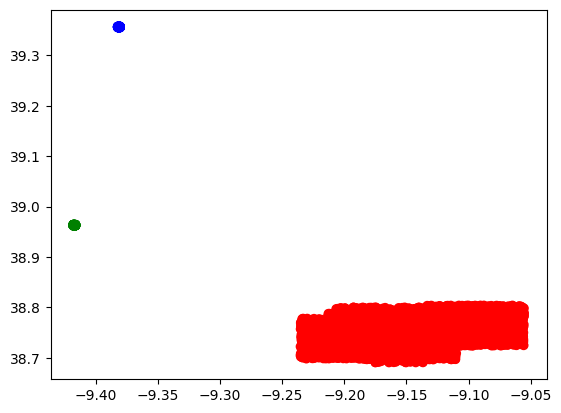

In [17]:
# Define a dictionary mapping city names to colors
color_dict = {'Lisbon': 'red', 'Peniche': 'blue', 'Ericeira': 'green', 'Other': 'gray'}

# Create a new column with colors based on the city
infotest['color'] = infotest['city'].map(color_dict)

# Create the scatter plot
plt.scatter(infotest['longitude'], infotest['latitude'], c=infotest['color'])
plt.show()

# **Dimensionality Reduction**